#1. Regresión lineal múltiple para calidad del aire
#Air Quality Data Set
Descripción: Contiene las respuestas de un dispositivo multisensor de gas desplegado sobre el terreno en una ciudad italiana. Los promedios de respuestas por hora se registran junto con referencias de concentraciones de gas de un analizador certificado.

https://archive.ics.uci.edu/ml//datasets/Air+quality

Instancias: 93584

Atributos: 15

0. Fecha (DD / MM / AAAA)
1. Hora (HH.MM.SS)
2. Concentración real promedio por hora de CO en mg / m ^ 3 
3. PT08.S1 (óxido de estaño) 
4. Concentración de hidrocarburos no metánicos total promediada por hora real en microg / m ^ 3 
5. Concentración de benceno promediada por hora real en microg / m ^ 3 
6. PT08.S2 (titania) respuesta del sensor promediada por hora
7. Concentración de NOx promediada por hora real en ppb
8. PT08.S3 (óxido de tungsteno) respuesta del sensor promediada por hora 
9. Concentración verdadera de NO2 promediada por hora en microg / m ^ 3 
10. PT08.S4 (óxido de tungsteno) respuesta del sensor promediada por hora 
11. PT08.S5 (óxido de indio) respuesta del sensor promediada por hora 
12. Temperatura en ° C
13. Humedad relativa (%)
14. AH de humedad absoluta

#2.Autenticación Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#3. Importando módulos

In [2]:
import pandas as pd
import os
import plotly.express as px
import plotly.io as pio
import numpy as np
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARIMA

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



#4. Lectura de archivo de calidad de aire

In [3]:
path = r'/content/drive/Shareddrives/Data Science para Geociencias/6. Métodos de ML/6.1 Regresión lineal múltiple'
name = 'AirQualityUCI.xlsx'

In [4]:
path_file = os.path.join(path,name)

In [5]:
air_quality = pd.read_excel(path_file)
air_quality.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754
1,2004-03-10,19:00:00,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487
2,2004-03-10,20:00:00,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239
3,2004-03-10,21:00:00,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713
4,2004-03-10,22:00:00,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794


In [6]:
print('Número de instancias: %s'%len(air_quality))
print('Número de atributos: %s'%(air_quality.shape[1]))

Número de instancias: 9357
Número de atributos: 15


#5. Limpieza de datos



**Modificando la columna de fecha: Unir Date y Time para formar la columna Fecha**

In [7]:
air_quality.loc[:,'Fecha'] = pd.to_datetime(air_quality.Date.astype(str)+' '+air_quality.Time.astype(str))
air_quality.drop(['Date','Time'], axis=1, inplace=True)

In [8]:
# Ordenando las columnas para que Fecha quede al principio :)
air_quality = air_quality[['Fecha','CO(GT)','PT08.S1(CO)','NMHC(GT)','C6H6(GT)','PT08.S2(NMHC)','NOx(GT)','PT08.S3(NOx)','NO2(GT)','PT08.S4(NO2)','PT08.S5(O3)','RH','AH','T']]
air_quality.head()

,Fecha,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),RH,AH,T
0,2004-03-10 18:00:00,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,48.875001,0.757754,13.60
1,2004-03-10 19:00:00,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,47.700000,0.725487,13.30
2,2004-03-10 20:00:00,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,53.975000,0.750239,11.90
3,2004-03-10 21:00:00,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,60.000000,0.786713,11.00
4,2004-03-10 22:00:00,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,59.575001,0.788794,11.15


**Graficar Fecha vs T**

In [9]:
fig=go.Figure()
fig.layout.template = "ggplot2" 
fig.add_scatter(x=air_quality['Fecha'], y=air_quality['T'], mode='lines',name='T')
fig.update_traces(marker=dict(size=3),
                  selector=dict(mode='markers'))
pio.show(fig)

**Verificando si existen NaNs**

In [10]:
print ('Conteo de valores faltantes: \n')
print (air_quality.isna().sum())

Conteo de valores faltantes: 

Fecha            0
CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
RH               0
AH               0
T                0
dtype: int64



**Identificación y reemplazo de los -200 con la media por columna**

**No olvides NO tomar en cuenta la columna de Fecha**

In [11]:
for i in range(air_quality.shape[1]-1):
  air_quality.iloc[:,i+1] = air_quality.iloc[:,i+1].replace(to_replace=-200, value=air_quality.iloc[:,i+1][air_quality.iloc[:,i+1]>0].mean())

In [12]:
fig=go.Figure()
fig.add_scatter(x=air_quality['Fecha'], y=air_quality['T'], mode='lines',name='T')
fig.update_traces(marker=dict(size=3),
                  selector=dict(mode='markers'))
pio.show(fig)

In [13]:
air_quality.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),RH,AH,T
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,2.152750,1099.707856,218.811816,10.082993,939.029205,246.881252,835.370973,113.075515,1456.143486,1022.780725,49.232360,1.025530,18.317216
std,1.316068,212.796116,63.870229,7.302474,261.557856,193.419417,251.741784,43.911095,339.365351,390.609000,16.974308,0.395836,8.658398
min,0.100000,647.250000,7.000000,0.149048,383.250000,2.000000,322.000000,2.000000,551.000000,221.000000,9.175000,0.184679,-1.900000
25%,1.200000,941.250000,218.811816,4.591495,742.500000,112.000000,665.500000,85.900000,1241.500000,741.750000,36.550000,0.746115,12.025000
50%,2.152750,1074.500000,218.811816,8.593367,923.250000,229.000000,817.500000,113.075515,1456.143486,982.500000,49.232360,1.015441,18.275000
75%,2.600000,1221.250000,218.811816,13.636091,1104.750000,284.200000,960.250000,133.000000,1662.000000,1255.250000,61.875000,1.296223,24.075000
max,11.900000,2039.750000,1189.000000,63.741476,2214.000000,1479.000000,2682.750000,339.700000,2775.000000,2522.750000,88.725000,2.231036,44.600000


**Escalamiento: estandarización**

**No olvides excluir la columna de Fecha**

In [14]:
scale = StandardScaler()
air_quality.iloc[:,1:-1] = scale.fit_transform(air_quality.iloc[:,1:-1])

In [15]:
air_quality.head()

,Fecha,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),RH,AH,T
0,2004-03-10 18:00:00,0.339856,1.223265,-1.077427,0.246331,0.407086,-0.418187,0.877450,-0.001720,0.695030,0.626540,-0.021054,-0.676520,13.60
1,2004-03-10 19:00:00,-0.116071,0.904868,-1.672415,-0.093922,0.060108,-0.743922,1.344223,-0.479984,0.302364,-0.129371,-0.090280,-0.758039,13.30
2,2004-03-10 20:00:00,0.035905,1.420648,-2.048197,-0.148612,0.000844,-0.599151,1.210150,0.021055,0.289840,0.131134,0.279416,-0.695505,11.90
3,2004-03-10 21:00:00,0.035905,1.296109,-2.173458,-0.116980,0.035255,-0.387165,1.019468,0.203251,0.376035,0.462045,0.634383,-0.603357,11.00
4,2004-03-10 22:00:00,-0.420023,0.810876,-2.627528,-0.488185,-0.395839,-0.599151,1.468365,0.066604,0.099770,0.223302,0.609344,-0.598098,11.15


#6. Hold out validation para series de tiempo


**Dividiendo el 80% de nuestros datos para entrenamiento y el 20% para validación, recuerda que en series de tiempo SI IMPORTA EL ORDEN**

In [16]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(air_quality.iloc[:,1:-1].to_numpy(), air_quality.iloc[:,-1].to_numpy(), test_size = 0.2, shuffle=False)

In [17]:
print(f'Dimension de los datos de entrenamiento {Xtrain.shape}')
print(f'Dimension de los datos de prueba {Xtest.shape}')

Dimension de los datos de entrenamiento (7485, 12)
Dimension de los datos de prueba (1872, 12)


#7. Modelo de inferencia: Regresión lineal múltiple

**Instanciando regresor**

In [18]:
linreg = LinearRegression(normalize=False)

**Ajuste con datos de entrenamiento**

In [19]:
linreg = linreg.fit(Xtrain, Ytrain)

## 7.1 Infieriendo temperaturas de prueba 

In [20]:
preds = linreg.predict(Xtest)

**Score de prueba**

In [21]:
linreg.score(Xtest, Ytest)

0.647122676196316

**MSE de prueba**

In [22]:
mean_squared_error(Ytest,preds)

13.270168795367095

**Comparación entre groundtruth y predicción**

In [23]:
n_train = int(0.8*air_quality.shape[0])
test_df =  air_quality.iloc[n_train:,:]
fig=go.Figure()
fig.add_scatter(x=test_df['Fecha'], y=Ytest, mode='lines',name='Ground Truth')
fig.add_scatter(x=test_df['Fecha'], y=preds, mode='lines',name='Predicted')
fig.update_traces(marker=dict(size=3),
                  selector=dict(mode='markers'))
pio.show(fig)

**Visualización de residuales**

In [24]:
fig=go.Figure()
fig.add_scatter(x=test_df['Fecha'], y=Ytest-preds, mode='lines',name='Residuales', line=go.scatter.Line(color="green"))
fig.add_scatter(x=test_df['Fecha'], y=np.zeros((len(Ytest))), mode='lines',name='Linea Base', line=go.scatter.Line(color="gray"))
fig.update_traces(marker=dict(size=3),
                  selector=dict(mode='markers'))
pio.show(fig)

# 8. Modelo de inferencia con XGBoostRegressor

**Instanciando regresor**

In [25]:
XGBR = XGBRegressor(normalize=False)

**Ajuste con los datos de entrenamiento**

In [26]:
XGBR = XGBR.fit(Xtrain,Ytrain)

[13:38:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


**Score de entrenamiento**

In [27]:
XGBR.score(Xtrain,Ytrain)

0.9975585117223964

## 8.1 Infiriendo temperaturas de prueba con XGBR

In [28]:
preds = XGBR.predict(Xtest)

**Score de prueba**

In [29]:
XGBR.score(Xtest,Ytest)

0.9549115892506226

**MSE de prueba**

In [30]:
mean_squared_error(Ytest,preds)

1.6955774174141967

**Comparación entre groundtruth y predicción**

In [31]:
fig=go.Figure()
fig.add_scatter(x=test_df['Fecha'], y=Ytest, mode='lines',name='Ground Truth')
fig.add_scatter(x=test_df['Fecha'], y=preds, mode='lines',name='Predicted')
fig.update_traces(marker=dict(size=3),
                  selector=dict(mode='markers'))
pio.show(fig)

**Visualización de residuales**

In [32]:
fig=go.Figure()
fig.add_scatter(x=test_df['Fecha'], y=Ytest-preds, mode='lines',name='Residuales', line=go.scatter.Line(color="green"))
fig.add_scatter(x=test_df['Fecha'], y=np.zeros((len(Ytest))), mode='lines',name='Linea Base', line=go.scatter.Line(color="gray"))
fig.update_traces(marker=dict(size=3),
                  selector=dict(mode='markers'))
pio.show(fig)

# 9. Modelo de inferencia con ARIMA

**Instanciando algoritmo**


**Ajuste con los datos de entrenamiento**

**Score de entrenamiento**

**Cambiando el dataframe para que solo tengamos fecha y T**

In [33]:
arimadf = air_quality.iloc[:,[0,-1]]
arimadf.head(10)

,Fecha,T
0,2004-03-10 18:00:00,13.600
1,2004-03-10 19:00:00,13.300
2,2004-03-10 20:00:00,11.900
3,2004-03-10 21:00:00,11.000
4,2004-03-10 22:00:00,11.150
5,2004-03-10 23:00:00,11.175
6,2004-03-11 00:00:00,11.325
7,2004-03-11 01:00:00,10.675
8,2004-03-11 02:00:00,10.650
9,2004-03-11 03:00:00,10.250


¿Es estacionaria? mean, variance y cov constantes en periodos de tiempo

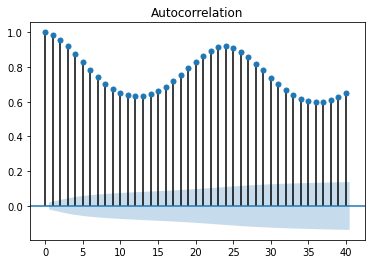

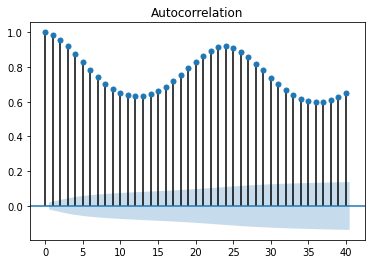

In [34]:
plot_acf(arimadf.iloc[:,1])

**Convertir la serie a estacionaria Integrated(1)**

In [35]:
arimadf_diff = air_quality.iloc[:,-1]
arimadf_diff.iloc[:] = arimadf_diff.iloc[:].diff(periods=1) 

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [36]:
arimadf_diff = arimadf_diff[1:]
arimadf_diff

1      -0.300000
2      -1.400000
3      -0.900000
4       0.150000
5       0.025000
          ...   
9352    3.700000
9353    2.475000
9354    2.574999
9355    1.425000
9356    0.175001
Name: T, Length: 9356, dtype: float64

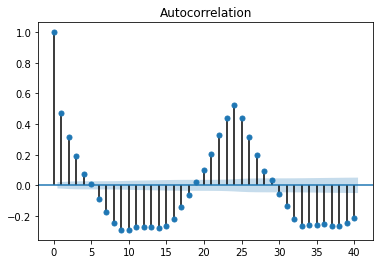

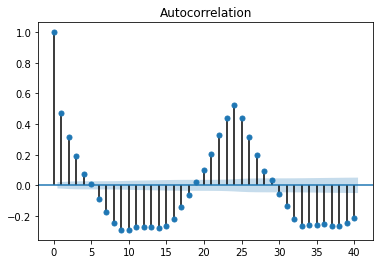

In [37]:
plot_acf(arimadf_diff)

In [38]:
fig=go.Figure()
fig.add_scatter(x=arimadf['Fecha'], y=arimadf_diff, mode='lines',name='', line=go.scatter.Line(color="green"))
fig.update_traces(marker=dict(size=3),
                  selector=dict(mode='markers'))
pio.show(fig)

In [39]:
n_train = int(0.95*air_quality.shape[0]) 
n_test = air_quality.shape[0]-n_train
 
train_df = arimadf.iloc[:n_train,:]
test_df =  arimadf.iloc[n_train:,:]
train = train_df.iloc[:n_train,1].to_numpy()
test =  test_df.iloc[n_train:,1].to_numpy()

## 9.1 Inferencia de temperaturas de prueba



In [40]:
model_arima = ARIMA(train,order=(10,1,10))

**Entrenamiento**

In [ ]:
model_arima_fit = model_arima.fit()

**Predicciones**

In [ ]:
preds = model_arima_fit.forecast(steps=n_test)[0]

**Visualización de los predichos vs. groundtruth**

In [ ]:
fig=go.Figure()
fig.add_scatter(x=test_df['Fecha'], y=test_df['T'], mode='lines',name='Ground Truth')
fig.add_scatter(x=test_df['Fecha'], y=preds, mode='lines',name='Predicted')
fig.update_traces(marker=dict(size=3),
                  selector=dict(mode='markers'))
pio.show(fig)